In [1]:
#
# * File:    Twitter_Persona_GloVe.py
# *
# * Author1:  Pavan Kumar K N (pavankumar.karkekopp@ucalgary.ca)
# * Date:     11th Aug 2019
# * Summary of File:
# * Explore mbti_1.csv file acquired from https://www.kaggle.com/datasnaek/mbti-type
# * Apply state-of-the-art reported publicly
# * Build classifier model that is better using machine learning techniques

#Just making sure the right environment is running this script
import sys
sys.executable

'C:\\ProgramData\\Anaconda3\\python.exe'

In [2]:
#Read Data
import numpy as np
import pandas as pd
import sklearn
import re
import pickle

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk import word_tokenize

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

from numpy import loadtxt
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
import pylab as pl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model
from keras import models
from keras import layers
from keras import regularizers

mbti_1 = pd.read_csv('data/mbti_1.csv') 
posts = mbti_1.posts
labels = mbti_1.type

BASE_DIR = ''
GLOVE_DIR = "data/glove.twitter.27B"
MAX_SEQUENCE_LENGTH = 2000
MAX_NB_WORDS = 2000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
NB_START_EPOCHS = 20
BATCH_SIZE = 512

GLOVE_DIM = 100


In [4]:
#Read the dataset
mbti_data = pd.read_csv("data/mbti_1.csv")

In [5]:
#Print first 5 entries in the dataset
mbti_data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [6]:
raw_posts = mbti_data.posts.values

In [7]:
#Split posts by the delimiter, which is ||| as we can see in row 0 and 4 above
filtered_posts = [p.split("|||") for p in raw_posts]

In [8]:
#Example of two tweets from row 0
for i in range(5):
    print("Tweet #{}:   {}".format(i+1,filtered_posts[0][i]))

Tweet #1:   'http://www.youtube.com/watch?v=qsXHcwe3krw
Tweet #2:   http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg
Tweet #3:   enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks
Tweet #4:   What has been the most life-changing experience in your life?
Tweet #5:   http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.


In [9]:
def encode_types(row):
    t=row['type']

    I = 0
    N = 0
    T = 0
    J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('Could not identify label for I-E')
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('Could not identify label for N-S')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('Could not identify label for T-F')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('Could not identify label for J-P')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

In [10]:
mbti_data_encoded = mbti_data.join(mbti_data.apply(lambda row: encode_types(row), axis=1))

In [11]:
mbti_data_encoded.head()

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


In [12]:
#Function to binarize the types into simple lists instead of pandas.series
personality_binary = {'I':1, 'E':0, 'N':1,'S':0, 'T':1, 'F':0, 'J':1, 'P': 0}
binary_personality = [{1:'I', 0:'E'}, 
                      {1:'N', 0:'S'},
                      {1:'T', 0:'F'},
                      {1:'J', 0:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    return [personality_binary[l] for l in personality]


def translate_binary(personality):
    # transform binary vector to mbti personality
    s = ""
    for i, l in enumerate(personality):
        s += binary_personality[i][l]
    return s



In [13]:
d = mbti_data_encoded.head(4)
list_personality_bin = np.array([translate_personality(p) for p in mbti_data_encoded.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[1 1 0 1]
 [0 1 1 0]
 [1 1 1 0]
 ...
 [1 1 1 0]
 [1 1 0 0]
 [1 1 0 0]]


### Data Preprocessing
* Remove urls
* Keep only words and make it lowercase
* Lemmatize each word
* Remove MBTI profiles strings. Too many appear in the posts!

In [14]:
mbti_data_encoded

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...,1,1,1,1
6,INFJ,"'No, I can't draw on my own nails (haha). Thos...",1,1,0,1
7,INTJ,'I tend to build up a collection of things on ...,1,1,1,1
8,INFJ,"I'm not sure, that's a good question. The dist...",1,1,0,1
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...,1,1,1,0


In [15]:
#List of strings to remove from the corpus
unique_type_list = ['INFJ', 
                    'ENTP', 
                    'INTP', 
                    'INTJ', 
                    'ENTJ', 
                    'ENFJ', 
                    'INFP', 
                    'ENFP',
                    'ISFP', 
                    'ISTP', 
                    'ISFJ', 
                    'ISTJ', 
                    'ESTP', 
                    'ESFP', 
                    'ESTJ', 
                    'ESFJ']

unique_type_list = [x.lower() for x in unique_type_list]

# Initialize for Lemmatization
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

def pre_process_data(data, remove_stop_words = True, remove_mbti_profiles = True):
    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if (i % 500 == 0 or i == 1 or i == len_data):
            print("%s of %s rows" % (i, len_data))

        ##### Remove and clean comments
        posts = row[1].posts
        filtered_post = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", posts)
        filtered_post_list = filtered_post.split("|||")
        j=0
        for pos in filtered_post_list:
            pos = re.sub("[^a-zA-Z]", " ", pos)
            pos = re.sub(" +", " ", pos).lower()
            if remove_stop_words:
                pos = " ".join([lemmatiser.lemmatize(w) for w in pos.split(' ') if w not in stopwords.words("english")])
            else:
                pos = " ".join([lemmatiser.lemmatize(w) for w in pos.split(' ')])

            #Removing occurrances of MBTI profile strings in tweets
            if remove_mbti_profiles:
                for t in unique_type_list:
                    pos = pos.replace(t, "")
                    
            if pos!= " ":
                filtered_post_list[j] = pos
            else:
                filtered_post_list[j] = None
    
            j += 1

            
#             print("Tweet #{}:   {}".format(j+1, pos))

        filtered_post_list = list(filter(None, filtered_post_list))
        type_labelized = translate_personality(row[1].type)
        list_personality.append(type_labelized)
        list_posts.append(" ".join(filtered_post_list))
#         print(filtered_post_list)

    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality


In [16]:
list_posts, list_personality  = pre_process_data(mbti_data_encoded, remove_stop_words=False)

1 of 8675 rows
500 of 8675 rows
1000 of 8675 rows
1500 of 8675 rows
2000 of 8675 rows
2500 of 8675 rows
3000 of 8675 rows
3500 of 8675 rows
4000 of 8675 rows
4500 of 8675 rows
5000 of 8675 rows
5500 of 8675 rows
6000 of 8675 rows
6500 of 8675 rows
7000 of 8675 rows
7500 of 8675 rows
8000 of 8675 rows
8500 of 8675 rows
8675 of 8675 rows


In [17]:
list_posts[0], list_personality[0]

(' and  moment sportscenter not top ten play prank what ha been the most life changing experience in your life   on repeat for most of today  may the perc experience immerse you  the last thing my  friend posted on his facebook before committing suicide the next day rest in peace  hello  sorry to hear of your distress it s only natural for a relationship to not be perfection all the time in every moment of existence try to figure the hard time a time of growth a  welcome and stuff   game set match  prozac wellbrutin at least thirty minute of moving your leg and i don t mean moving them while sitting in your same desk chair weed in moderation maybe try edible a a healthier alternative  basically come up with three item you ve determined that each type or whichever type you want to do would more than likely use given each type cognitive function and whatnot when left by  all thing in moderation sims is indeed a video game and a good one at that note a good one at that is somewhat subject

#### Embedding Matrix with GloVe

In [18]:
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open(os.path.join(GLOVE_DIR, glove_file), encoding="utf-8")
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [19]:
airline_words = ['airplane', 'airline', 'flight', 'luggage']
for w in airline_words:
    if w in emb_dict.keys():
        print('Found the word {} in the dictionary:{}'.format(w,emb_dict[w]))

Found the word airplane in the dictionary:[ 0.24663    0.15368    0.66699   -0.47329    0.48851    0.56863
 -0.27034   -0.56281    0.47398   -0.59753   -0.019399   0.20907
 -1.9358    -0.039432   0.006689  -0.20946    0.44273    0.87527
 -0.010597  -0.27101   -1.3333    -0.66836    0.45542   -0.2994
  0.91341    0.87099   -0.45495    0.093829   0.31513    0.56531
  0.24558   -0.54483    0.32325   -0.55472    0.038418   0.40444
  0.22255    0.27899    0.25924    0.023309   0.46968    0.62029
 -0.17067   -0.70975    0.79782   -0.17841    0.36865   -0.0076834
 -0.35966    0.086881   0.31657    0.91939   -0.20271   -0.18098
 -0.31798    0.41899    0.1277    -0.5368     0.27473   -0.12952
  0.9968     0.27832    0.37444    0.066832  -1.0672    -0.65536
 -0.27039   -0.11158    0.16106   -0.02075   -0.24849    0.34627
 -0.27947   -0.76005   -0.087761  -0.0748    -0.76778   -0.25303
  1.2236    -0.12425    1.2025     0.41603    0.037124   0.1475
  0.29442   -0.6001     0.01312   -0.40055   -1.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(list_posts, list_personality, test_size=0.2, random_state=37)

In [21]:
X_train[0]

' i m not crazy about ska but i do like some song band it s more like that with all music i listen to i really listen to anything but there s part of anything that i really don t care for but not  lsd is really fun and open other possibility i have never imagined you don t just think out of the box you get thrown onto another box into some other plain of existence i wanna try dmt  i have no idea i still can t get passed free basing meteoric moon rock  well i really don t think about fashion alot i ll order a cool shirt off the net if i come across one but for the most part i really don t buy clothing or accessory that and i shave my head once  yeah i ve gotten that a few time maybe i m just a strange  lol   what aspect of your personality made you unsure of your type well i m pretty sure i m extroverted although i m currently going through a slump in my social life due to financial situation i  i never think about it but i pretty much do whatever suit my fancy i don t have a problem be

In [22]:
tk =  Tokenizer(num_words=MAX_NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(list_posts)

In [23]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [ ]:
seq_len = []
for tweet in X_train:
    seq_len.append(len(tweet.split(" ")))

In [ ]:
pd.Series(seq_len).describe()

count    6940.000000
mean     1358.421902
std       332.771039
min         3.000000
25%      1170.000000
50%      1414.000000
75%      1602.000000
max      2059.000000
dtype: float64

In [ ]:
MAX_SEQUENCE_LENGTH = 2000 #based on above

In [ ]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
emb_matrix = np.zeros((MAX_NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < MAX_NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [ ]:
X_train_seq_trunc[16]

array([ 0,  0,  0, ...,  2, 75, 88])

In [ ]:
#Splitting Vallidation data
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (694, 2000)


# Modelling

### Helper Functions

In [ ]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

### Vanilla Embedding Layer

In [ ]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(MAX_NB_WORDS, 8, input_length=MAX_SEQUENCE_LENGTH))
emb_model.add(layers.Flatten())
emb_model.add(layers.Dense(4, activation='softmax'))
emb_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 8)           16000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 64004     
Total params: 80,004
Trainable params: 80,004
Non-trainable params: 0
_________________________________________________________________


In [ ]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Instructions for updating:
Use tf.cast instead.
Train on 6246 samples, validate on 694 samples
Epoch 1/20
6246/6246 [==============================] - 3s 471us/step - loss: 3.3256 - acc: 0.3023 - val_loss: 3.3530 - val_acc: 0.1873
Epoch 2/20
6246/6246 [==============================] - 0s 24us/step - loss: 3.2762 - acc: 0.3212 - val_loss: 3.3475 - val_acc: 0.1844
Epoch 3/20
6246/6246 [==============================] - 0s 23us/step - loss: 3.2422 - acc: 0.3317 - val_loss: 3.3368 - val_acc: 0.2550
Epoch 4/20
6246/6246 [==============================] - 0s 24us/step - loss: 3.2047 - acc: 0.3849 - val_loss: 3.3532 - val_acc: 0.2233
Epoch 5/20
6246/6246 [==============================] - 0s 24us/step - loss: 3.1630 - acc: 0.4336 - val_loss: 3.3422 - val_acc: 0.2507
Epoch 6/20
6246/6246 [==============================] - 0s 23us/step - loss: 3.1183 - acc: 0.4614 - val_loss: 3.3530 - val_acc: 0.2810
Epoch 7/20
6246/6246 [==============================] - 0s 23us/step - loss: 3.0728 - acc: 0.4

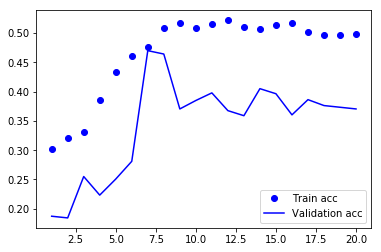

In [ ]:
eval_metric(emb_history, 'acc')

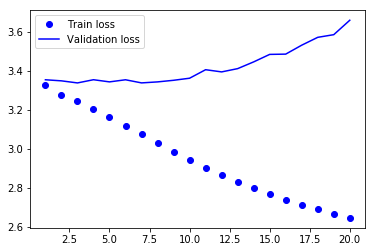

In [ ]:
eval_metric(emb_history, 'loss')

In [ ]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train, X_test_seq_trunc, y_test, 20)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

1735/1735 [==============================] - 0s 38us/step
/n
Test accuracy of word embeddings model: 37.58%


### GloVe Embedding with Softmax

In [ ]:
emb_matrix = np.zeros((MAX_NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < MAX_NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [ ]:
glove_model = models.Sequential()
glove_model.add(layers.Embedding(MAX_NB_WORDS, GLOVE_DIM, input_length=MAX_SEQUENCE_LENGTH))
glove_model.add(layers.Flatten())
glove_model.add(layers.Dense(4, activation='softmax'))
glove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 100)         200000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 200000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 800004    
Total params: 1,000,004
Trainable params: 1,000,004
Non-trainable params: 0
_________________________________________________________________


In [ ]:
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False

In [ ]:
glove_history = deep_model(glove_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Train on 6246 samples, validate on 694 samples
Epoch 1/20
6246/6246 [==============================] - 0s 59us/step - loss: 22.4833 - acc: 0.2542 - val_loss: 26.5938 - val_acc: 0.1844
Epoch 2/20
6246/6246 [==============================] - 0s 36us/step - loss: 25.9807 - acc: 0.2065 - val_loss: 26.5400 - val_acc: 0.1844
Epoch 3/20
6246/6246 [==============================] - 0s 35us/step - loss: 25.6296 - acc: 0.2779 - val_loss: 25.9293 - val_acc: 0.2032
Epoch 4/20
6246/6246 [==============================] - 0s 35us/step - loss: 25.0117 - acc: 0.2944 - val_loss: 23.8338 - val_acc: 0.2939
Epoch 5/20
6246/6246 [==============================] - 0s 36us/step - loss: 25.3373 - acc: 0.6204 - val_loss: 27.0271 - val_acc: 0.7637
Epoch 6/20
6246/6246 [==============================] - 0s 35us/step - loss: 26.4102 - acc: 0.5653 - val_loss: 24.7172 - val_acc: 0.1729
Epoch 7/20
6246/6246 [==============================] - 0s 36us/step - loss: 25.4851 - acc: 0.3732 - val_loss: 27.5952 - val_acc: 0

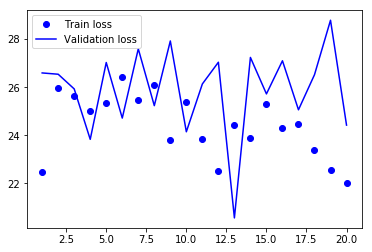

In [ ]:
eval_metric(glove_history, 'loss')

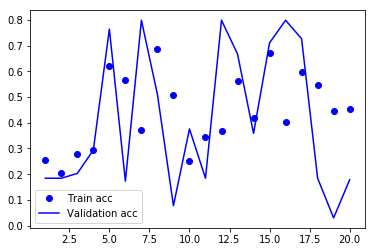

In [ ]:
eval_metric(glove_history, 'acc')

In [ ]:
glove_results = test_model(glove_model, X_train_seq_trunc, y_train, X_test_seq_trunc, y_test, 20)
print('/n')
print('Test accuracy of word glove model: {0:.2f}%'.format(glove_results[1]*100))

1735/1735 [==============================] - 0s 67us/step
/n
Test accuracy of word glove model: 26.11%


## Classifiers

In [ ]:
type_indicators = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) – Sensing (S)", 
                   "FT: Feeling (F) - Thinking (T)", "JP: Judging (J) – Perceiving (P)"  ]

for l in range(len(type_indicators)):
    print(type_indicators[l])
    print(y_test[:,l])

IE: Introversion (I) / Extroversion (E)
[1 1 1 ... 1 1 1]
NS: Intuition (N) – Sensing (S)
[1 1 1 ... 0 0 1]
FT: Feeling (F) - Thinking (T)
[0 1 1 ... 0 0 1]
JP: Judging (J) – Perceiving (P)
[0 0 0 ... 0 0 1]


In [ ]:
for l in range(len(type_indicators)):
    print("\n\n{} ...".format(type_indicators[l]))
    
    y_train_class = y_train[:,l]
    y_test_class = y_test[:,l]
    
    print(X_train_seq_trunc.shape, y_train_class.shape)
    seed = 7
    sm = SMOTE(random_state=2)
    X_train_res , y_train_res = sm.fit_sample(X_train_seq_trunc, y_train_class.ravel())
    
    model = XGBClassifier(learning_rate=0.01,
                             n_estimators=5000,
                             max_depth=4,
                             min_child_weight=6,
                             colsample_bytree=0.8,
                             objective='binary:logistic',
                             nthread=8,
                             scale_pos_weight=1,
                             seed=7)

    model.fit(X_train_res, y_train_res)
    
    # make predictions for test data
    y_pred = model.predict(X_test_seq_trunc)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = sklearn.metrics.accuracy_score(y_test_class, predictions)
    f1_score_measure = sklearn.metrics.f1_score(y_test_class, predictions)
    rmse = sklearn.metrics.mean_squared_error(y_test_class, predictions)
    mae = sklearn.metrics.mean_absolute_error(y_test_class, predictions)
    print(" Accuracy: {:.2f}% \t F1-Score: {:.3f} RMSE: {:.3f} MAE: {:.3f}".format(accuracy * 100.0, f1_score_measure, rmse, mae))
    



IE: Introversion (I) / Extroversion (E) ...
(6940, 2000) (6940,)
 Accuracy: 74.52% 	 F1-Score: 0.853 RMSE: 0.255 MAE: 0.255


NS: Intuition (N) – Sensing (S) ...
(6940, 2000) (6940,)
 Accuracy: 85.71% 	 F1-Score: 0.923 RMSE: 0.143 MAE: 0.143


FT: Feeling (F) - Thinking (T) ...
(6940, 2000) (6940,)
 Accuracy: 54.01% 	 F1-Score: 0.480 RMSE: 0.460 MAE: 0.460


JP: Judging (J) – Perceiving (P) ...
(6940, 2000) (6940,)
 Accuracy: 56.83% 	 F1-Score: 0.282 RMSE: 0.432 MAE: 0.432


In [ ]:
from tabulate import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
encoding = "utf-8"

In [ ]:
X, y = np.array(list_posts), np.array(list_personality)
print ("total examples %s" % len(y))

total examples 8675


In [ ]:
with open(os.path.join(GLOVE_DIR, glove_file), "rb") as lines:
    wvec = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

In [ ]:
import struct 

glove_dict = {}
all_words = set(w for words in X)
with open(os.path.join(GLOVE_DIR, glove_file), "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_dict[word] = nums

In [ ]:
# start with the classics - naive bayes of the multinomial and bernoulli varieties
# with either pure counts or tfidf features
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
# SVM - which is supposed to be more or less state of the art 
# http://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf
svc = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])

In [ ]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_dict))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

    
# and a tf-idf version of the same
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_dict))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [ ]:
etree_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_dict)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_small_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_dict)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

In [ ]:
all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ("glove_small", etree_glove_small),
    ("glove_small_tfidf", etree_glove_small_tfidf),
]


type_indicators = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) – Sensing (S)", 
                   "FT: Feeling (F) - Thinking (T)", "JP: Judging (J) – Perceiving (P)"  ]

for l in range(len(type_indicators)):
    print(type_indicators[l])
    y = list_personality[:,l]
    unsorted_scores = [(name, cross_val_score(model, X, y, cv=5).mean()) for name, model in all_models]
    scores = sorted(unsorted_scores, key=lambda x: -x[1])
    print (tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

IE: Introversion (I) / Extroversion (E)
model                score
-----------------  -------
mult_nb_tfidf       0.7696
svc                 0.7696
svc_tfidf           0.7696
glove_small         0.7696
glove_small_tfidf   0.7696
bern_nb             0.7695
bern_nb_tfidf       0.7695
mult_nb             0.6989
NS: Intuition (N) – Sensing (S)
model                score
-----------------  -------
mult_nb_tfidf       0.8620
svc                 0.8620
svc_tfidf           0.8620
glove_small         0.8620
glove_small_tfidf   0.8620
bern_nb             0.8619
bern_nb_tfidf       0.8619
mult_nb             0.8221
FT: Feeling (F) - Thinking (T)
model                score
-----------------  -------
svc                 0.6442
mult_nb             0.6225
svc_tfidf           0.5691
mult_nb_tfidf       0.5411
glove_small         0.5411
glove_small_tfidf   0.5411
bern_nb             0.5395
bern_nb_tfidf       0.5395
JP: Judging (J) – Perceiving (P)
